In [2]:
import pandas as pd
import sys
import time
import random
import asyncio
import datetime
from datetime import timedelta
from termcolor import colored
%load_ext autoreload


# Download data from Quotex

In [3]:
%autoreload 2
from quotexpy import Quotex
from quotexpy.utils import asset_parse
from quotexpy.utils.account_type import AccountType
from quotexpy.utils.candles_period import CandlesPeriod
from quotexpy.utils.operation_type import OperationType

In [7]:

asset_current = "USDBDT"


def on_pin_code() -> str:
    code = input("Enter the code sent to your email: ")
    return code


client = Quotex(
    email="qaviinan@gmail.com",
    password="qoutexpass4567",
    headless=True,
    on_pin_code=on_pin_code,
)

In [8]:
await client.connect()

Trying to get ssid


True

## First login to qoutex
    1. Install from source
    2. Debug to find login issues
    3. Solve and login using selenium or whatever
### Second run get_candle_v2 to get and store candles over a time period (24-48 hrs)
### Next run some basic strategies on minute tick data
### Combine with daily level trend data (using investing csv)

In [40]:
def check_asset(asset):
    asset_query = asset_parse(asset)
    asset_open = client.check_asset(asset_query)
    if not asset_open or not asset_open[2]:
        print(colored("[WARN]: ", "yellow"), "Asset is closed.")
        asset = f"{asset}_otc"
        print(colored("[WARN]: ", "yellow"), "Try OTC Asset -> " + asset)
        asset_query = asset_parse(asset)
        asset_open = client.check_asset(asset_query)
    return asset, asset_open

In [41]:
async def get_candle_v2():
    check_connect = await client.connect()
    if check_connect:
        global asset_current
        asset, asset_open = check_asset(asset_current)
        if asset_open[2]:
            print(colored("[INFO]: ", "blue"), "Asset is open.")
            candles = await client.get_candle_v2(asset, CandlesPeriod.ONE_MINUTE)
            return candles
        else:
            print(colored("[INFO]: ", "blue"), "Asset is closed.")
    client.close()

In [43]:
candles = await get_candle_v2()

Trying to get ssid
[WARN]:  Asset is closed.
[WARN]:  Try OTC Asset -> USDBDT_otc
[INFO]:  Asset is open.


In [44]:
df = pd.DataFrame(candles)
df['time'] = pd.to_datetime(df['time'], unit='s')  # Convert timestamp to datetime
df.set_index('time', inplace=True)
df.index = df.index.tz_localize('UTC').tz_convert('Asia/Dhaka')

In [45]:
def get_filename(df):
    """
    Generates a filename based on the candles data.

    Args:
        candles: List of candle data.

    Returns:
        Filename in the format "bdt-DDYY-last_time-first_time.csv".
    """
    last_time = df.index.max().strftime('%H%M')
    first_time = df.index.min().strftime('%H%M')
    date = datetime.datetime.now().strftime('%d%y')
    return f"bdt-{date}-{last_time}-{first_time}.csv"
filename = get_filename(df)
df.to_csv(f"data/{filename}")

In [28]:
df

,open,close,high,low
time,,,,
2024-09-12 21:55:00+06:00,126.129,126.124,126.131,126.124
2024-09-12 21:54:00+06:00,126.148,126.129,126.151,126.120
2024-09-12 21:53:00+06:00,126.102,126.148,126.164,126.102
2024-09-12 21:52:00+06:00,126.089,126.102,126.112,126.068
2024-09-12 21:51:00+06:00,126.085,126.085,126.103,126.078
...,...,...,...,...
2024-09-12 18:42:00+06:00,126.330,126.276,126.333,126.276
2024-09-12 18:41:00+06:00,126.261,126.328,126.333,126.261
2024-09-12 18:40:00+06:00,126.231,126.261,126.261,126.229


In [29]:
capture_range = df.index.sort_values()[-1] - df.index.sort_values()[0]
next_time = df.index.sort_values()[-1] + capture_range
print(f"run again at {next_time}")

run again at 2024-09-13 01:12:00+06:00


In [32]:
last_time = df.index.max().strftime('%H%M')
first_time = df.index.min().strftime('%H%M')
date = datetime.datetime.now().strftime('%d%y')
print(f"bdt-{date}-{last_time}-{first_time}.csv")

bdt-1224-2155-1838.csv


In [36]:
pd.read_csv('data/USD_BDT_daily.csv')

,Date,Price,Open,High,Low,Vol.,Change %
0,08/26/2024,118.722,118.562,118.722,118.562,NaN,0.14%
1,08/25/2024,118.562,118.562,118.562,118.562,NaN,-0.83%
2,08/23/2024,119.550,119.590,119.780,119.550,NaN,0.46%
3,08/22/2024,119.000,119.250,119.500,119.250,NaN,0.21%
4,08/21/2024,118.750,119.250,119.250,119.250,NaN,-0.04%
...,...,...,...,...,...,...,...
323,06/01/2023,107.230,108.200,108.200,107.280,NaN,0.03%
324,05/31/2023,107.200,108.150,108.150,107.250,NaN,-0.04%
325,05/30/2023,107.240,108.500,108.500,107.290,NaN,0.06%
326,05/29/2023,107.180,108.350,108.350,107.230,NaN,-0.02%


In [35]:
dk = pd.read_csv('data/USD_BDT_2022-2024.csv')
dk.index
# dk.plot()

RangeIndex(start=0, stop=666, step=1)

In [39]:
# dk.set_index('Date')
pd.to_datetime(dk.Date)

0     2024-09-12
1     2024-09-11
2     2024-09-10
3     2024-09-09
4     2024-09-06
         ...    
661   2022-01-07
662   2022-01-06
663   2022-01-05
664   2022-01-04
665   2022-01-03
Name: Date, Length: 666, dtype: datetime64[ns]

In [31]:
# SQLITE
import schedule

# SQLITE

In [38]:
import sqlite3

# Load CSV data into a DataFrame
dailydf = pd.read_csv('data/USD_BDT_daily.csv')

# Create a SQLite database
conn = sqlite3.connect("data/ohlcv__daily_data.db")

# Write DataFrame to the database
dailydf.to_sql("ohlcv", conn, index=False)

328

In [39]:
# Read data from the database back into a DataFrame
df_from_db = pd.read_sql_query("SELECT * FROM ohlcv", conn)

# Close the database connection
conn.close()

# Analyze the data in df_from_db
print(df_from_db.head())  # Print the first few rows

         Date    Price     Open     High      Low  Vol. Change %
0  08/26/2024  118.722  118.562  118.722  118.562  None    0.14%
1  08/25/2024  118.562  118.562  118.562  118.562  None   -0.83%
2  08/23/2024  119.550  119.590  119.780  119.550  None    0.46%
3  08/22/2024  119.000  119.250  119.500  119.250  None    0.21%
4  08/21/2024  118.750  119.250  119.250  119.250  None   -0.04%


# Statistical tests

In [55]:
df_from_db['time'] = pd.to_datetime(df_from_db['Date'])
df_from_db.index = df_from_db.time

In [41]:
df_from_db.describe()

,Price,Open,High,Low
count,328.000000,328.000000,328.000000,328.000000
mean,111.298677,111.536003,111.623457,111.430948
std,3.413658,3.430660,3.429369,3.501958
min,107.180000,107.178000,107.205000,106.746000
25%,109.500000,109.741000,109.750000,109.633750
50%,109.718500,109.750000,109.797000,109.750000
75%,110.500000,110.750000,110.832750,110.750000
max,119.550000,119.590000,119.780000,119.550000


In [44]:
df_from_db[['Open', 'High']].corr()

,Open,High
Open,1.000000,0.998062
High,0.998062,1.000000


In [56]:
from statsmodels.tsa.stattools import adfuller
# series = read_csv('daily-total-female-births.csv', header=0, index_col=0, squeeze=True)
X = df_from_db.Price.diff().dropna()
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.359618
p-value: 0.000000
Critical Values:
	1%: -3.451
	5%: -2.870
	10%: -2.572


<Axes: xlabel='time'>

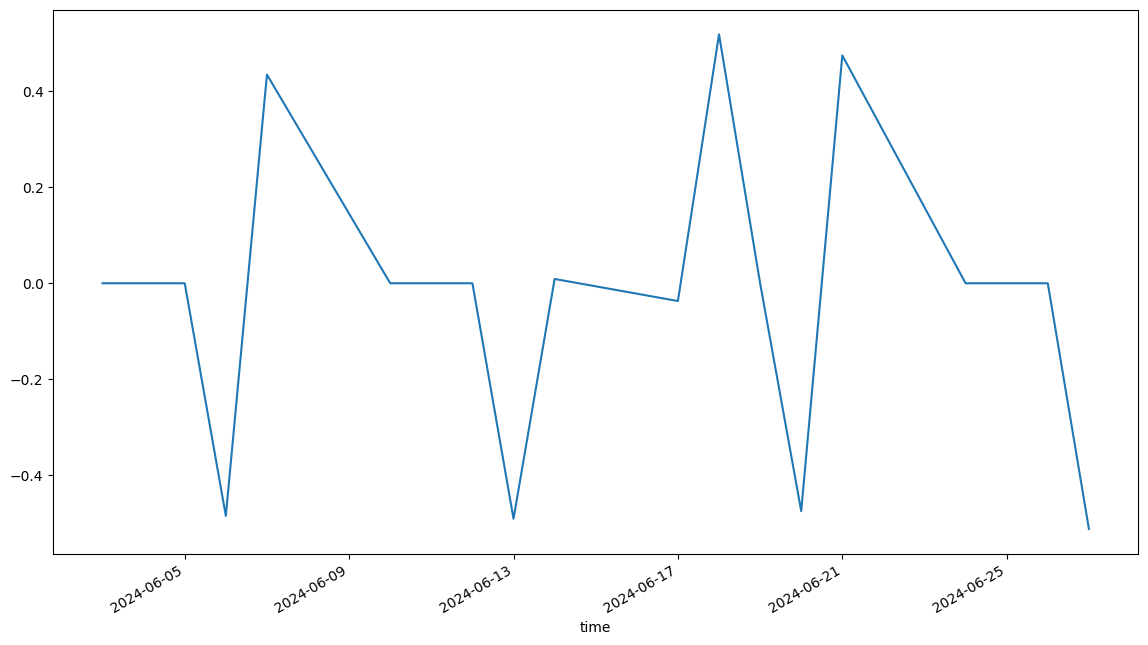

In [69]:
df_from_db.loc["2024-06"].Price.diff().dropna().plot(figsize=(14,8))

In [68]:
df_from_db.loc["2024-06"]

,Date,Price,Open,High,Low,Vol.,Change %,time
time,,,,,,,,
2024-06-28,06/28/2024,117.512,117.537,117.567,117.447,None,0.44%,2024-06-28
2024-06-27,06/27/2024,117.000,117.500,117.500,117.500,None,0.00%,2024-06-27
2024-06-26,06/26/2024,117.000,117.500,117.500,117.500,None,0.00%,2024-06-26
2024-06-25,06/25/2024,117.000,117.500,117.500,117.500,None,0.00%,2024-06-25
2024-06-24,06/24/2024,117.000,117.500,117.500,117.500,None,-0.40%,2024-06-24
2024-06-21,06/21/2024,117.475,117.480,117.739,117.475,None,0.41%,2024-06-21
2024-06-20,06/20/2024,117.000,117.500,117.500,117.500,None,0.00%,2024-06-20
2024-06-19,06/19/2024,117.000,117.500,117.500,117.500,None,-0.44%,2024-06-19
2024-06-18,06/18/2024,117.519,117.482,117.519,117.220,None,0.03%,2024-06-18


In [82]:
df_from_db.sort_values(by=['Price'], ascending=False).Price[0]

/tmp/ipykernel_7443/4076477819.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_from_db.sort_values(by=['Price'], ascending=False).Price[0]


np.float64(119.55)

In [71]:
0.4*100000/117

341.88034188034186

In [ ]:
# Clear weekly seasonality in the data
# Next step extract and predict seasonality
# Finally, create separate and combined strategies for daily trend, weekly seasonality (bb vs lag-regression) and minute level data (bb)

# Hourly data sample 1

In [3]:
df = pd.read_csv('data/bdt-1324-0300-2000.csv')
df['time'] = pd.to_datetime(df.time)
df.set_index('time', inplace=True)

In [4]:
df

,open,close,high,low
time,,,,
2024-09-13 03:00:00+06:00,126.604,126.800,126.812,126.412
2024-09-13 02:00:00+06:00,126.665,126.606,126.685,126.475
2024-09-13 01:00:00+06:00,126.397,126.669,126.745,126.370
2024-09-13 00:00:00+06:00,126.242,126.397,126.554,126.234
2024-09-12 23:00:00+06:00,126.096,126.242,126.305,126.092
...,...,...,...,...
2024-09-05 00:00:00+06:00,125.844,125.692,125.889,125.608
2024-09-04 23:00:00+06:00,125.601,125.844,125.981,125.509
2024-09-04 22:00:00+06:00,125.759,125.601,125.974,125.595


# backtest

In [9]:
# Calculate lower and upper quantiles for 'low' and 'high' prices
low_threshold = df['low'].quantile(0.05)  # 10% quantile
high_threshold = df['high'].quantile(0.95)  # 90% quantile

print('Low price threshold:', low_threshold)
print('High price threshold:', high_threshold)

Low price threshold: 125.45039999999999
High price threshold: 129.08655


In [15]:
# First connect a simple backtesting utility
# Then test with mavg crossover
# Then bollinger bands

def bollinger_indicator(df, span=36, factor=1):
    expiry = 4
    prices = df.iloc[-1*span:]['close']
    upper = prices.mean() + (factor* prices.std())
    lower = prices.mean() - (factor*prices.std())
    current_price = df.iloc[-1]['close']
    last_price = df.iloc[-2]['close']
    if (last_price<upper) and (current_price>=upper):
        # Upper break
        return (-1, expiry*60)
    elif (last_price>lower) and (current_price<=lower):
        # Lower break
        return (1, expiry*60)
    else:
        return (0,0)

def test_indicator(candles, span):
    """
    signals:
    buy: 1
    sell: -1
    nothing: 0

    expiry in minutes

    returns
    (signal, expiry)
    """
    # print('Current candle:', candles.iloc[-1]['close'], 'Previous candle:', candles.iloc[-2]['close'])
    if (candles.iloc[-1]['close'] < 124.5) and (candles.iloc[-2]['close'] >= 124.5):
        print('BUY')
        return (1, 240)
    elif (candles.iloc[-1]['close'] > 128.0) and (candles.iloc[-2]['close'] <= 128.0):
        return (-1, 240)
    else:
        return (0, 0)


def calculate_bet_pnl(bet_type, amount, opening_price, current_price):
    if bet_type == "buy":
        # Needs to go up to win
        if current_price > opening_price:
            return amount * 0.9
        else:
            return -1 * amount
    elif bet_type == "sell":
        # Needs to go down to win
        if current_price < opening_price:
            return amount * 0.9
        else:
            return -1 * amount
    return 0

def optionBot(candles_df, indicator, indicator_count):
    BUY_AMOUNT = 1000
    SELL_AMOUNT = 1000
    TRADES = pd.DataFrame(columns=["expiry", "open", "type", "amount", "price", "pnl"])
    OPEN_TRADES = pd.DataFrame(columns=["expiry", "open", "type", "amount", "price"])
    BUY_STOCK = 0
    MAX_BUY = 10000
    SELL_STOCK = 0
    MAX_SELL = 10000
    candles_df.sort_index(inplace=True)
    for i in range(indicator_count, len(candles_df)):
        candles = candles_df.iloc[:i]

        signal, expiry = indicator(candles, indicator_count)
        current_time = candles.iloc[-1].name
        current_price = candles.iloc[-1].close
        
        # CHECK SIGNALS AND PLACE TRADES
        if signal==1 and BUY_STOCK<MAX_BUY:
            # Bet going up
            bet_amount = BUY_AMOUNT
            expiry_time = current_time + timedelta(minutes=expiry)
            # TRADES.append(['buy', current_time, bet_amount, buying_price, expiry])
            # print('------------Adding new BUY trade---------------')
            # print([expiry_time, current_time, 'buy', bet_amount, current_price])
            OPEN_TRADES.loc[len(OPEN_TRADES)] = [expiry_time, current_time, 'buy', bet_amount, current_price]
            BUY_STOCK += bet_amount
        if signal==-1 and SELL_STOCK<MAX_SELL:
            # Bet going down
            bet_amount = SELL_AMOUNT
            expiry_time = current_time + timedelta(minutes=expiry)
            # To be removed
            # print('------------Adding new SELL trade---------------')
            # print([expiry_time, current_time, 'sell', bet_amount, current_price])
            OPEN_TRADES.loc[len(OPEN_TRADES)] = [expiry_time, current_time, 'sell', bet_amount, current_price]
            SELL_STOCK += bet_amount
        
        # CHECK EXPIRIES AND CLOSE TRADES
        expired_orders = OPEN_TRADES.loc[OPEN_TRADES['expiry']<=current_time]
        # Calculate pnl for each expired trade
        for _, trade in expired_orders.iterrows():
            trade_pnl = calculate_bet_pnl(trade['type'], trade['amount'], trade['price'], current_price)
            if trade["type"]=="buy":
                BUY_STOCK -= trade['amount']
            else:
                SELL_STOCK -= trade['amount']
            # Add closed trades to final trades list
            TRADES.loc[len(TRADES)] = [trade['expiry'], trade['open'], trade['type'], trade['amount'], trade['price'], trade_pnl]
        # Remove expired orders from main dataframe
        OPEN_TRADES = OPEN_TRADES.loc[OPEN_TRADES['expiry'] > current_time]
    return TRADES, OPEN_TRADES

In [16]:
trades,opens  = optionBot(df, bollinger_indicator, 12)
trades.pnl.sum()

np.float64(-1300.0)

In [19]:
spanres = {}
for span in range(4, 48, 2):
    trades,opens  = optionBot(df, bollinger_indicator, span)
    spanres[span] = trades.pnl.sum()

<Axes: >

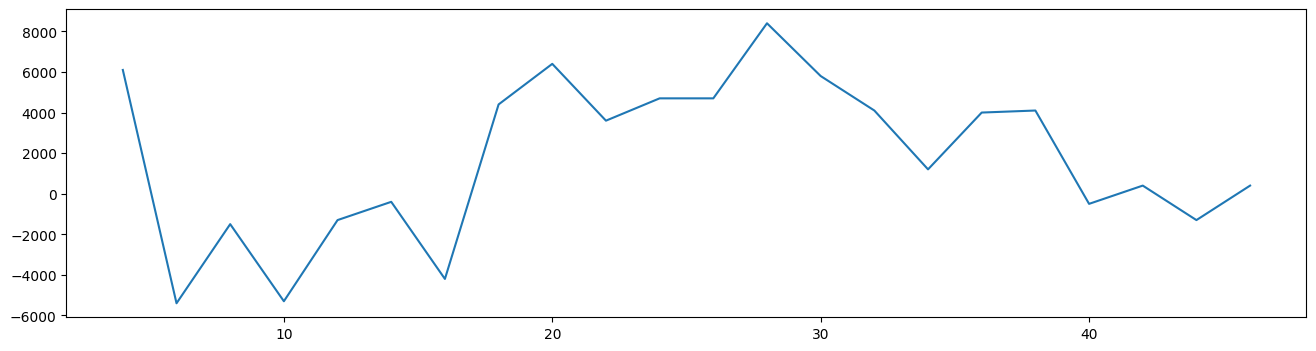

In [24]:
pd.Series(spanres).plot(figsize=(16,4))

In [21]:
trades,opens  = optionBot(df, bollinger_indicator, 24)
trades

,expiry,open,type,amount,price,pnl
0,2024-09-06 04:00:00+06:00,2024-09-06 00:00:00+06:00,buy,1000,125.635,900.0
1,2024-09-06 05:00:00+06:00,2024-09-06 01:00:00+06:00,buy,1000,125.500,900.0
2,2024-09-06 10:00:00+06:00,2024-09-06 06:00:00+06:00,buy,1000,125.679,900.0
3,2024-09-06 17:00:00+06:00,2024-09-06 13:00:00+06:00,sell,1000,126.998,-1000.0
4,2024-09-07 00:00:00+06:00,2024-09-06 20:00:00+06:00,sell,1000,127.259,900.0
5,2024-09-07 15:00:00+06:00,2024-09-07 11:00:00+06:00,buy,1000,125.919,900.0
6,2024-09-08 03:00:00+06:00,2024-09-07 23:00:00+06:00,sell,1000,127.386,-1000.0
7,2024-09-08 16:00:00+06:00,2024-09-08 12:00:00+06:00,sell,1000,128.229,-1000.0
8,2024-09-09 02:00:00+06:00,2024-09-08 22:00:00+06:00,sell,1000,128.880,900.0
9,2024-09-09 05:00:00+06:00,2024-09-09 01:00:00+06:00,sell,1000,128.878,900.0


In [ ]:
trades,opens  = optionBot(df, bollinger_indicator, span)

<Axes: xlabel='time'>

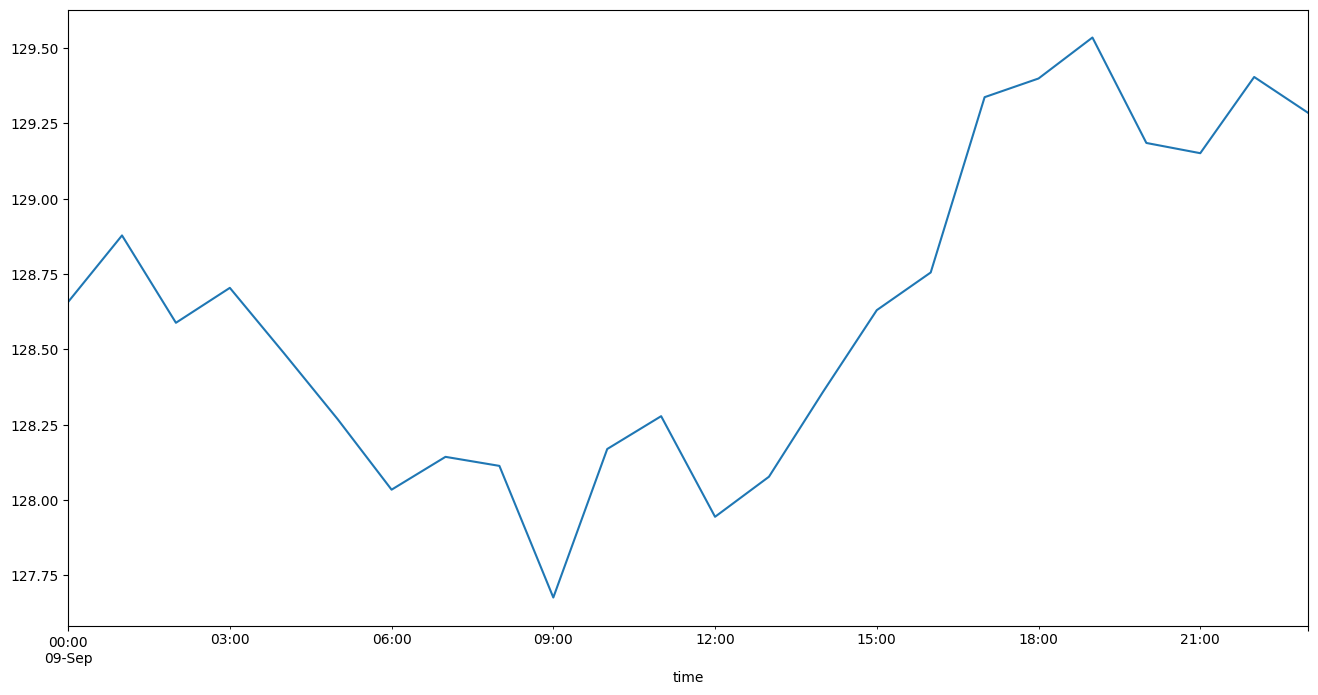

In [54]:
df.loc["2024-09-09"].close.plot(figsize=(16,8))

# Stats

<!-- # First, probability distribution of returns
# Second, conditional probabilities for each new return given past
# Then I need ema forecasts in 4 time lengths: 1m, 5m, 15m, 1h
# Say 1h,15m showing bull, but 1m in downtrend: now probability heavy toward positive 1m bars?
# Backtest using prob-based approach, use kelly-criterion for sizing -->

In [58]:
df.sort_index(inplace=True)

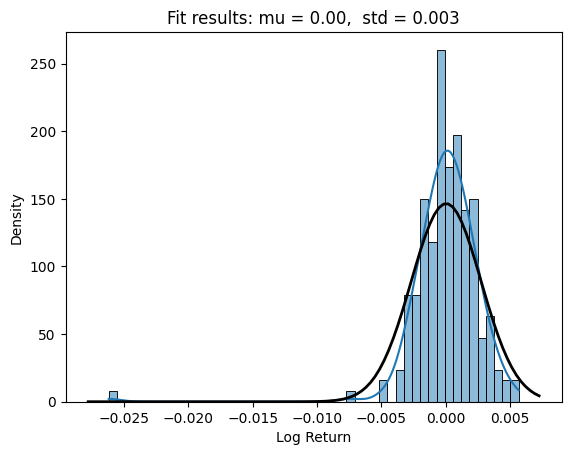

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Assuming you have a DataFrame `df` with a 'price' column
df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# Drop NaN values (from shift operation)
returns = df['log_return'].dropna()

# Plotting histogram and fitting a normal distribution
sns.histplot(returns, bins=50, kde=True, stat="density")
mu, std = norm.fit(returns)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title(f'Fit results: mu = {mu:.2f},  std = {std:.3f}')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.show()

# Information 1: Price will be within 124-128 range
    > Q1: Is price near boundary? (if so it will mean revert) = long-term bollinger bands
    > Q2: Is price trending in one direction? (If so chances increase of mean reversion) = shorter term bollinger bands
# Information 2: Trend exists in 15m, 1hr ranges
    > Q1: Use EMA to score trends in these timeranges
# Information 3: Instant mean reversion in 5s, 10s ranges
    > Q1: Quick bollinger bands in these ranges, or simply rule based reversion

In [5]:
# 1.1 Long-term bollinger bands
def bollinger_indicator(df, span, factor = 1):
    prices = df.iloc[-1*span:]['close']
    upper = prices.mean() + (factor* prices.std())
    lower = prices.mean() - (factor*prices.std())
    current_price = df.iloc[-1]['close']
    last_price = df.iloc[-2]['close']
    if (last_price<upper) and (current_price>=upper):
        # Upper break
        return (-1, span*60)
    elif (last_price>lower) and (current_price<=lower):
        # Lower break
        return (1, span*60)


,open,close,high,low
count,200.000000,200.000000,200.00000,200.000000
mean,126.847805,126.852080,127.05424,126.656175
std,1.055455,1.053584,1.05257,1.041270
min,125.320000,125.323000,125.48800,125.186000
25%,125.989000,125.991500,126.20250,125.814250
50%,126.565000,126.584500,126.79850,126.389000
75%,127.474000,127.475500,127.71775,127.296500
max,129.535000,129.535000,129.57100,129.322000


concepts:
Skewness: Assess the asymmetry of the distribution.
Kurtosis: Evaluate the "tailedness" of the distribution.
Autocorrelation
T-test